# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from dqn_agent import Agent                       
from math import exp

import matplotlib.pyplot as plt

#Params
n_episodes=700
max_t=1500


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [5]:
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")
#env = UnityEnvironment(file_name="Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [8]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
# score = 0                                          # initialize the score
# while True:
#     action = np.random.randint(action_size)        # select an action
#     env_info = env.step(action)[brain_name]        # send the action to the environment
#     next_state = env_info.vector_observations[0]   # get the next state
#     reward = env_info.rewards[0]                   # get the reward
#     done = env_info.local_done[0]                  # see if episode has finished
#     score += reward                                # update the score
#     state = next_state                             # roll over the state to next time step
#     if done:                                       # exit loop if episode finished
#         break
    
# print("Score: {}".format(score))

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [9]:
import random
from collections import deque

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

def dqn(agent, agent_name=None, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_mean = []
    scores_window = deque(maxlen=300)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0                                          # initialize the score
        
        for t in range(max_t):
            action = agent.act(state, eps)                 # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state                             # roll over the state to next time step
            score += reward                                # update the score
            if done:                                       # exit loop if episode finished
                break
        
            
            
        mean = np.mean(scores_window)
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        scores_mean.append( mean )
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            
            if agent_name is None:            
                torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            else:
                torch.save(agent.qnetwork_local.state_dict(), agent_name + '_checkpoint.pth')
            break
            
    return scores, scores_mean

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.43657523 1.
 0.         0.         0.         0.19398789 1.         0.
 0.         0.         0.47860974 0.         0.         1.
 0.         0.52109712 0.         0.         1.         0.
 0.38285938 1.         0.         0.         0.         0.10405888
 1.         0.         0.         0.         0.37148568 0.
 0.        ]
States have length: 37


/home/bmendonca/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bmendonca/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 100	Average Score: 0.41
Episode 200	Average Score: 1.26
Episode 300	Average Score: 2.39
Episode 400	Average Score: 4.85
Episode 500	Average Score: 7.44
Episode 600	Average Score: 9.11
Episode 700	Average Score: 9.91
Episode 800	Average Score: 10.36
Episode 900	Average Score: 10.87
Episode 1000	Average Score: 11.07
Episode 1100	Average Score: 11.29
Episode 1200	Average Score: 11.84
Episode 1300	Average Score: 12.64
Episode 1341	Average Score: 13.00
Environment solved in 1241 episodes!	Average Score: 13.00


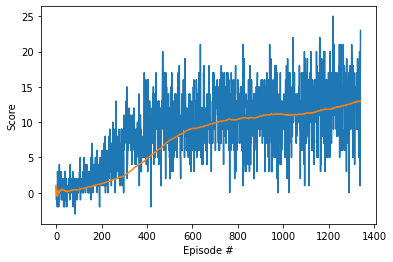

In [7]:
n_episodes=2000
max_t=600

dqn_agent = Agent( state_size=state_size, action_size=action_size, seed=0, ddqn=False, dueling=False  )
dqn_scores, dqn_scores_mean = dqn( dqn_agent, agent_name="vanilla", n_episodes=n_episodes, max_t=max_t, eps_start=1.0, eps_end=0.01, eps_decay=0.995 )

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(dqn_scores)), dqn_scores)
plt.plot(np.arange(len(dqn_scores)), dqn_scores_mean)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

/home/bmendonca/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bmendonca/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 100	Average Score: 0.43
Episode 200	Average Score: 1.86
Episode 300	Average Score: 3.40
Episode 400	Average Score: 6.08
Episode 500	Average Score: 8.11
Episode 600	Average Score: 9.60
Episode 700	Average Score: 10.41
Episode 800	Average Score: 11.23
Episode 900	Average Score: 11.59
Episode 1000	Average Score: 11.89
Episode 1100	Average Score: 11.91
Episode 1200	Average Score: 12.17
Episode 1300	Average Score: 12.60
Episode 1342	Average Score: 13.01
Environment solved in 1242 episodes!	Average Score: 13.01


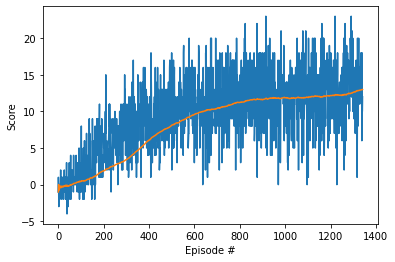

In [8]:
ddqn_agent = Agent( state_size=state_size, action_size=action_size, seed=0, ddqn=True, dueling=False  )
ddqn_scores, ddqn_scores_mean = dqn( ddqn_agent, agent_name="ddqn", n_episodes=n_episodes, max_t=max_t, eps_start=1.0, eps_end=0.01, eps_decay=0.995 )

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(ddqn_scores)), ddqn_scores)
plt.plot(np.arange(len(ddqn_scores)), ddqn_scores_mean)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

/home/bmendonca/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bmendonca/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 100	Average Score: 0.75
Episode 200	Average Score: 1.81
Episode 300	Average Score: 2.81
Episode 400	Average Score: 4.51
Episode 500	Average Score: 5.97
Episode 600	Average Score: 7.30
Episode 700	Average Score: 8.43
Episode 800	Average Score: 9.56
Episode 900	Average Score: 10.31
Episode 1000	Average Score: 10.90
Episode 1100	Average Score: 11.15
Episode 1200	Average Score: 11.67
Episode 1300	Average Score: 12.08
Episode 1400	Average Score: 12.33
Episode 1500	Average Score: 12.57
Episode 1600	Average Score: 12.86
Episode 1627	Average Score: 13.02
Environment solved in 1527 episodes!	Average Score: 13.02


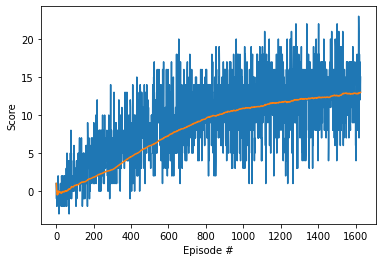

In [9]:
dueling_agent = Agent( state_size=state_size, action_size=action_size, seed=0, ddqn=False, dueling=True  )
dueling_scores, dueling_scores_mean = dqn( dueling_agent, agent_name="duelling", n_episodes=n_episodes, max_t=max_t, eps_start=1.0, eps_end=0.01, eps_decay=0.995 )

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(dueling_scores)), dueling_scores)
plt.plot(np.arange(len(dueling_scores)), dueling_scores_mean)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

/home/bmendonca/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bmendonca/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 100	Average Score: 0.66
Episode 200	Average Score: 1.98
Episode 300	Average Score: 3.50
Episode 400	Average Score: 6.03
Episode 500	Average Score: 8.10
Episode 600	Average Score: 9.37
Episode 700	Average Score: 10.07
Episode 800	Average Score: 10.29
Episode 900	Average Score: 10.82
Episode 1000	Average Score: 11.27
Episode 1100	Average Score: 11.93
Episode 1200	Average Score: 12.51
Episode 1300	Average Score: 12.72
Episode 1399	Average Score: 13.00
Environment solved in 1299 episodes!	Average Score: 13.00


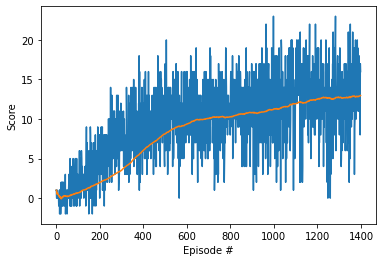

In [10]:
dueling_ddqn_agent = Agent( state_size=state_size, action_size=action_size, seed=0, ddqn=True, dueling=True  )
dueling_ddqn_scores, dueling_ddqn_scores_mean = dqn( dueling_ddqn_agent, agent_name="duelling_ddqn", n_episodes=n_episodes, max_t=max_t, eps_start=1.0, eps_end=0.01, eps_decay=0.995 )

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(dueling_ddqn_scores)), dueling_ddqn_scores)
plt.plot(np.arange(len(dueling_ddqn_scores)), dueling_ddqn_scores_mean)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [11]:
##!! DISCLAIMER

#For some reasen to be further diagnosed, this type of training is very slow, even using GPU. Probably some misuse of pytorch.


# beta_scheduler = lambda x,h=2*12000: 1.0-exp(-x/h)

# prioritize_dueling_ddqn_agent = Agent( state_size=state_size, action_size=action_size, seed=0, ddqn=True, dueling=True, prioritize_weight=0.4, beta_scheduler=beta_scheduler )
# prioritize_dueling_ddqn_scores, prioritize_dueling_ddqn_scores_mean = dqn( prioritize_dueling_ddqn_agent, agent_name="prioritize_dueling_ddqn_agent", n_episodes=n_episodes, max_t=max_t, eps_start=1.0, eps_end=0.01, eps_decay=0.995 )

# # plot the scores
# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.plot(np.arange(len(prioritize_dueling_ddqn_scores)), prioritize_dueling_ddqn_scores)
# plt.plot(np.arange(len(prioritize_dueling_ddqn_scores)), prioritize_dueling_ddqn_scores_mean)
# plt.ylabel('Score')
# plt.xlabel('Episode #')
# plt.show()

NameError: name 'dqn_scores' is not defined

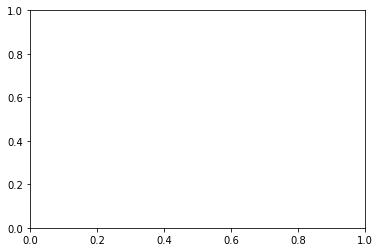

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot( np.arange( len(dqn_scores) ), dqn_scores_mean )
plt.plot( np.arange( len(ddqn_scores)), ddqn_scores_mean )
plt.plot( np.arange( len(dueling_scores)), dueling_scores_mean )
plt.plot( np.arange( len(dueling_ddqn_scores)), dueling_ddqn_scores_mean )
#plt.plot(np.arange( len(prioritize_dueling_ddqn_scores)), prioritize_dueling_ddqn_scores_mean )

np.savetxt('dqn_scores.txt',  ( np.arange( len(dqn_scores) ), dqn_scores, dqn_scores_mean  ) )
np.savetxt('ddqn_scores.txt',  ( np.arange( len(ddqn_scores) ), ddqn_scores, ddqn_scores_mean  ) )
np.savetxt('duelling_scores.txt',  ( np.arange( len(dueling_scores) ), dueling_scores, dueling_scores_mean ) )
np.savetxt('duelling_ddqn_scores.txt',  ( np.arange( len(dueling_ddqn_scores) ), dueling_ddqn_scores, dueling_ddqn_scores_mean ) )

plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(['DQN', 'Double DQN', 'Duelling DQN', 'Duelling Double DQN'])
plt.show()

In [14]:
#Loading up the saved model

#agent_type = "dqn"
#agent_type = "ddqn"
#agent_type = "duelling_dqn"
agent_type = "duelling_ddqn"

if agent_type is "dqn":
    agent = Agent( state_size=state_size, action_size=action_size, seed=0, ddqn=False, dueling=False )
    checkpoint = 'vanilla_checkpoint.pth'    
    
elif agent_type is "ddqn":
    agent = Agent( state_size=state_size, action_size=action_size, seed=0, ddqn=True, dueling=False )
    checkpoint = 'ddqn_checkpoint.pth'    

elif agent_type is "duelling_dqn":
    agent = Agent( state_size=state_size, action_size=action_size, seed=0, ddqn=False, dueling=True )
    checkpoint = 'duelling_checkpoint.pth'    
    
elif agent_type is "duelling_ddqn":
    agent = Agent( state_size=state_size, action_size=action_size, seed=0, ddqn=True, dueling=True )
    checkpoint = 'duelling_ddqn_checkpoint.pth'    


agent.qnetwork_local.load_state_dict(torch.load(checkpoint))


env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state, 0.0)                 # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 15.0
